<a href="https://colab.research.google.com/github/MalikaIT21277122/TimeSeriesAnalysis/blob/main/Random_Forest_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Step 1: Load the dataset
file_name = "CESAW_project_summary.csv"
data = pd.read_csv(file_name)

# Step 2: Add a Project Name column (generated project names for illustration)
data['Project_Name'] = [f"Project_{i+1}" for i in range(len(data))]

# Display the first few rows to verify
print("Dataset Preview:")
print(data.head())

# Step 3: Data cleaning
# Check and handle missing values
if data.isnull().values.any():
    print("\nHandling missing values...")
    data.fillna(data.mean(), inplace=True)
    print("Missing values filled with column means.")

# Remove duplicates (if any)
data.drop_duplicates(inplace=True)

# Ensure all columns have appropriate data types
data['Start_Date'] = pd.to_datetime(data['Start_Date'], errors='coerce')
data['End_Date'] = pd.to_datetime(data['End_Date'], errors='coerce')
data.dropna(subset=['Start_Date', 'End_Date'], inplace=True)  # Remove rows with invalid dates

# Drop rows with outliers in numeric columns
numeric_cols = ['Team_Size', 'A&M_LoC', 'Effort_Hours', 'Duration_Days']
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
data = data[~((data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

# Step 4: Feature scaling and normalization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Team_Size', 'A&M_LoC', 'Effort_Hours']])
X = pd.DataFrame(scaled_features, columns=['Team_Size', 'A&M_LoC', 'Effort_Hours'])
y = data['Duration_Days']

# Step 5: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Dataset Preview:
       Org  Project_Key  Team_Size  Start_Date    End_Date  A&M_LoC  \
0  Org_250       157350         10  2021-03-24  2021-08-30     2047   
1  Org_524       840484          7  2018-05-17  2018-11-22   478998   
2  Org_374       158681         20  2022-10-13  2023-04-30   293213   
3  Org_622       671484         12  2021-06-30  2021-10-17   652223   
4  Org_304       716168          7  2023-04-25  2023-10-26   878154   

   Effort_Hours  Duration_Days Project_Name  
0       12087.6            159    Project_1  
1       37311.7            189    Project_2  
2       49957.5            199    Project_3  
3       11725.4            109    Project_4  
4        1706.1            184    Project_5  


Hyperparameter Tuning and Model Optimization

In [12]:
# Step 6: Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)

# Step 7: Train the optimized Random Forest model
best_rf.fit(X_train, y_train)

# Step 8: Predict and evaluate the model
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Model Evaluation, Visualization, and Predictions


Model Evaluation Metrics:
Mean Squared Error (MSE): 10259.14
Mean Absolute Error (MAE): 87.49
R² Score: -0.09


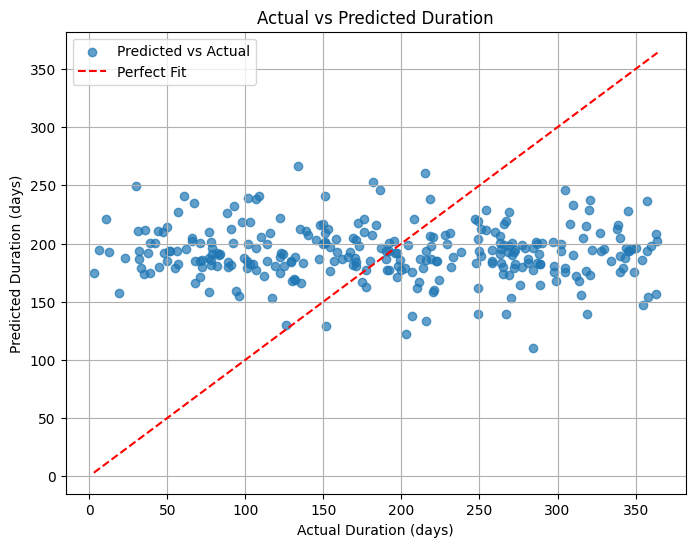

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Project Name: Sample_Project
Predicted Duration for sample input: 184.65 days


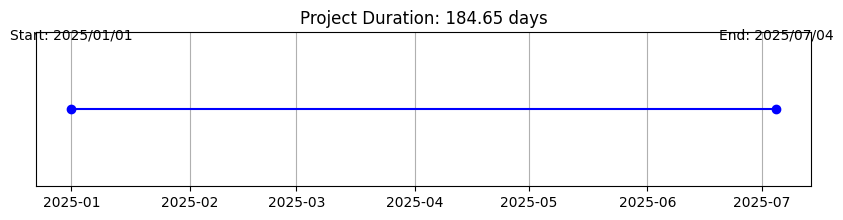


Improved Model Accuracy: 54.28%


In [13]:
print("\nModel Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 9: Visualize Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Perfect Fit")
plt.title("Actual vs Predicted Duration")
plt.xlabel("Actual Duration (days)")
plt.ylabel("Predicted Duration (days)")
plt.legend()
plt.grid(True)
plt.show()

# Step 10: Predict for a sample input
sample_input = pd.DataFrame({
    'Project_Name': ['Sample_Project'],  # Add project name
    'Team_Size': [30],
    'A&M_LoC': [250000],
    'Effort_Hours': [7500]
})

# Extract numerical features for prediction
sample_input_features = sample_input[['Team_Size', 'A&M_LoC', 'Effort_Hours']]
sample_input_scaled = scaler.transform(sample_input_features)
predicted_duration = best_rf.predict(sample_input_scaled)[0]

print(f"\nProject Name: {sample_input['Project_Name'][0]}")
print(f"Predicted Duration for sample input: {predicted_duration:.2f} days")

# Step 11: Time bar visualization
def plot_time_bar(start_date, predicted_duration):
    """Plots a time bar from the start date for the predicted duration."""
    end_date = start_date + timedelta(days=predicted_duration)
    plt.figure(figsize=(10, 2))
    plt.plot([start_date, end_date], [1, 1], marker='o', linestyle='-', color='blue')
    plt.text(start_date, 1.05, f"Start: {start_date.strftime('%Y/%m/%d')}", ha='center')
    plt.text(end_date, 1.05, f"End: {end_date.strftime('%Y/%m/%d')}", ha='center')
    plt.title(f"Project Duration: {predicted_duration:.2f} days")
    plt.yticks([])
    plt.grid(True)
    plt.show()

# Example time bar for the predicted duration
sample_start_date = datetime.strptime("2025-01-01", "%Y-%m-%d")  # Example start date
plot_time_bar(sample_start_date, predicted_duration)

# Step 12: Accuracy Calculation
average_duration = y.mean()
accuracy = 1 - (mae / average_duration)
print(f"\nImproved Model Accuracy: {accuracy:.2%}")
